## Table of contents
1. [Introduction](#intro)
2. [Obtain games id with beautifulsoup4](#bs4)
3. [Additional information through API calls](#bggapi)
4. [Some data processing](#processing)

----
<a href="https://boardgamegeek.com/" target="_blank">
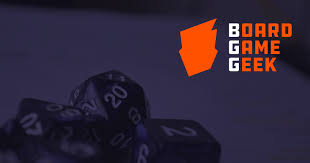
</a>

### Introduction <a name="intro">

I enjoy playing board games. Sometimes, I wish to find similar games to the ones I like. But since they come in a variety of genres and categories, it can be hard to find similar games. So, let us obtain data and use the power of algorithms. 

In this post, my goal is to (responsibly) collect data from [BGG](https://boardgamegeek.com/), and process them into a clean format. Using [beautifulsoup4](https://pypi.org/project/beautifulsoup4/) and [BGG API](https://boardgamegeek.com/wiki/page/BGG_XML_API2), we will collect a list of board games, together with the following features:
   - Game ID
   - Year Published
   - Designer
   - Geek Rating/Average Rating
   - Number of Voters
   - Mechanisms
   - Categories
   - Complexity
    
I stumbled upon this very nice [post](http://sdsawtelle.github.io/blog/output/boardgamegeek-data-scraping.html) doing this task. I have incorporated many of the author's great ideas here. 

### Obtain games id with beautifulsoup4

Through the API, one can obtain all information that we want. However, in order to send queries, one would need to know the games id in the database. We will obtain these information by scraping through `https://boardgamegeek.com/browse/boardgame/page/<page number>` by incrementing `page number`. There are a lot of games, so we will only collect games that have a board game rank. At the time of writing, this means that we will go through about 200 pages.

In [2]:
# import libraris for scraping, parsing, and storing
import requests
from bs4 import BeautifulSoup
import pandas as pd
from time import sleep
import lxml

To responsibly collect data, let us introduce a wrapper function that includes an internal timer, so that we don't ping the server too quickly. 

In [2]:
def request(msg, slp=2):
    status_code = 500 # initialization, we want a status code 200
    while status_code != 200:
        sleep(slp)
        try:
            r = requests.get(msg)
            status_code = r.status_code
            if status_code != 200:
                print('Server error, code %i. Retrying...' % status_code)
        except:
            print('An exception has occured. Retrying...')
    return r

In [4]:
# scraping function, returning a dataframe containing rank and id
def scrape():
    main = pd.DataFrame(columns=['rank', 'game_id'])
    rank_val = True #initialize rank validation
    page_num = 1 #initialize page number
    basic_url = 'https://boardgamegeek.com/browse/boardgame/page/'
    while rank_val==True:
        # Get HTML from request
        r = request(basic_url + str(page_num))
        soup = BeautifulSoup(r.text)
        # For the current page, define a Pandas dataframe with the same columns as main
        rows = soup.find_all("tr", attrs={"id":"row_"})
        table = pd.DataFrame(columns=['rank', 'game_id'], index=range(len(rows)))
        for i in range(len(rows)):
            try: #get rank if applicable
                rank = int(rows[i].select("td.collection_rank a")[0].get('name'))
            except:
                rank_val = False
                break # stop looping through rows since rank_val is already False
            gameid = int(rows[i].select("td.collection_thumbnail a")[0].get("href").split("/")[2])
            
            table.iloc[i,:] = [rank, gameid]
        table = table.dropna() # only take the nonnull  rows
        
        # Concatenate the current page's dataframe into the main table
        print('page {} scraped' .format(page_num))
        main = pd.concat([main,table], axis = 0)
        page_num += 1
        sleep(1)
    main.reset_index(inplace=True,drop=True)
    return main
    

In [6]:
# scraping data, coffee recommended
index = scrape()

page 1 scraped
page 2 scraped
page 3 scraped
page 4 scraped
page 5 scraped
page 6 scraped
page 7 scraped
page 8 scraped
page 9 scraped
page 10 scraped
page 11 scraped
page 12 scraped
page 13 scraped
page 14 scraped
page 15 scraped
page 16 scraped
page 17 scraped
page 18 scraped
page 19 scraped
page 20 scraped
page 21 scraped
page 22 scraped
page 23 scraped
page 24 scraped
page 25 scraped
page 26 scraped
page 27 scraped
page 28 scraped
page 29 scraped
page 30 scraped
page 31 scraped
page 32 scraped
page 33 scraped
page 34 scraped
page 35 scraped
page 36 scraped
page 37 scraped
page 38 scraped
page 39 scraped
page 40 scraped
page 41 scraped
page 42 scraped
page 43 scraped
page 44 scraped
page 45 scraped
page 46 scraped
page 47 scraped
page 48 scraped
page 49 scraped
page 50 scraped
page 51 scraped
page 52 scraped
page 53 scraped
page 54 scraped
page 55 scraped
page 56 scraped
page 57 scraped
page 58 scraped
page 59 scraped
page 60 scraped
page 61 scraped
page 62 scraped
page 63 scraped
p

*Note: for some reason, there are games occupying multiple ranks, leading to duplicate game ids in our table. If I have to guess, it might be database updating delays, but I'm not so sure. In any case, we need to take only the unique ones*.

In [8]:
index_unique = pd.DataFrame(index.game_id.unique())
index_unique.columns=['game_id']
index_unique

,game_id
0,174430
1,161936
2,224517
3,167791
4,233078
...,...
20110,16398
20111,7316
20112,5048
20113,5432


In [15]:
# output to csv
index_unique.to_csv("bggdata/bgg_index.csv", index=False, encoding="utf-8")

*Note: We could have also obtained the titles, certain ratings and number of voters. However, let us obtain these information through API calls instead.*

One can definitely take nice break here.

### Additional information through API calls


In [3]:
# resuming our work, let's create a fresh index table here
df = pd.read_csv('bggdata/bgg_index.csv')

#### What we want and example API call
We will use [BGG XML API 2](https://boardgamegeek.com/wiki/page/BGG_XML_API2). 
For example, to obtain information on the rank 1 game *Gloomhaven*, we make a request using the following URL: 
https://www.boardgamegeek.com/xmlapi2/thing?id=174430&stats=1

This gives us an XML file that we can parse. We might want the following information:

* Title
* Description
* Number of players
* Game categories
* Game families
* Average rating
* Number of ratings
* Various ranks: overall, thematic, strategy, etc.
* Number of owners
* Complexity weight

#### API calls
It is possible to obtain information from multiple games at once. We limit the number to 1000 games per call. Since things like mechanics and categories have their own ids, we also make sure to record them.

In [23]:
def api_calls():
    cols = ['game_id','title','Year', 'description', 'players_range','playtime', 'categories',
            'mechanics','families', 'avg_rating','num_voters', 'owners', 
            'ranks', 'complexity']
    main = pd.DataFrame(columns= cols)
    URL = 'https://www.boardgamegeek.com/xmlapi2/thing?stats=1&id='
    # Create dictionaries for these for later use
    category_dict={}
    mechanism_dict={}
    family_dict={}
    rank_dict={}
    for k in range(len(df)//1000 + 1):
        # slicing index table to get the parts we want
        if 1000*(k+1) < len(df.index):
            table = df.loc[1000*k:1000*(k+1)-1]
        else:
            table = df.loc[1000*k:]
        # Concatenate game IDs into string
        extension = ','.join(table.game_id.astype(str))
        
        # API calls for current list of games
        r = request(URL + extension)
        soup = BeautifulSoup(r.text, "xml")
        
        # Info gathering
        # Table slice containing slice info
        table = pd.DataFrame(columns=cols, index = range(1000))
        
        # Getting a list of item tags, one per game
        item_list = soup.find_all('item', type='boardgame')
        
        # Looping over item_list, acquire info into table
        for i in range(len(item_list)):
            game_id = item_list[i].get('id')
            title = item_list[i].find('name',type='primary').get('value')
            year = int(item_list[i].find('yearpublished').get('value'))
            description = item_list[i].find('description').getText()
            players_range = [int(item_list[i].find('minplayers').get('value')),
                              int(item_list[i].find('maxplayers').get('value'))]
            playtime=[int(item_list[i].find('minplaytime').get('value')),
                              int(item_list[i].find('maxplaytime').get('value'))]
            
            
            categories = []
            for entry in item_list[i].find_all('link', type='boardgamecategory'):
                categories.append(int(entry.get('id')))
                if entry.get('id') not in category_dict:
                    category_dict[entry.get('id')] = entry.get('value')
                    
                    
                
            mechanics = []
            for entry in item_list[i].find_all('link', type='boardgamemechanic'):
                mechanics.append(int(entry.get('id')))
                if entry.get('id') not in mechanism_dict:
                    mechanism_dict[entry.get('id')] = entry.get('value')
                
            families = []
            for entry in item_list[i].find_all('link', type='boardgamefamily'):
                families.append(int(entry.get('id')))
                if entry.get('id') not in family_dict:
                    family_dict[entry.get('id')] = entry.get('value')
                
            avg_rating = item_list[i].find('average').get('value')
            num_voters = item_list[i].find('usersrated').get('value')
            owners = item_list[i].find('owned').get('value')
            complexity = item_list[i].find('averageweight').get('value')
            
            ranks = []
            for entry in item_list[i].find_all('rank'):
                ranks.append((int(entry.get('id')),int(entry.get('value'))))
                if entry.get('id') not in rank_dict:
                    rank_dict[entry.get('id')] = entry.get('name')
                
            
            table.loc[i,:] = [game_id,title,year,description,players_range,
                              playtime,
                               categories,mechanics,families,avg_rating,
                               num_voters,owners,ranks,complexity]
        table.dropna(inplace=True)
        main = pd.concat([main,table], axis=0)
        main.reset_index(inplace=True,drop=True)
        print('{}-th round succeeded' .format(k+1))
        sleep(5)
    category_frame = pd.Series(category_dict)
    mechanism_frame = pd.Series(mechanism_dict)
    family_frame = pd.Series(family_dict)
    rank_frame = pd.Series(rank_dict)
    return main,category_frame, mechanism_frame, family_frame,rank_frame

In [24]:
all_data = api_calls()

d:\projects\projectbgg\venv\lib\site-packages\pandas\core\internals\blocks.py:983: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


1-th round succeeded


d:\projects\projectbgg\venv\lib\site-packages\pandas\core\internals\blocks.py:983: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


2-th round succeeded


d:\projects\projectbgg\venv\lib\site-packages\pandas\core\internals\blocks.py:983: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


3-th round succeeded


d:\projects\projectbgg\venv\lib\site-packages\pandas\core\internals\blocks.py:983: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


4-th round succeeded


d:\projects\projectbgg\venv\lib\site-packages\pandas\core\internals\blocks.py:983: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


5-th round succeeded


d:\projects\projectbgg\venv\lib\site-packages\pandas\core\internals\blocks.py:983: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


6-th round succeeded


d:\projects\projectbgg\venv\lib\site-packages\pandas\core\internals\blocks.py:983: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


7-th round succeeded


d:\projects\projectbgg\venv\lib\site-packages\pandas\core\internals\blocks.py:983: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


8-th round succeeded


d:\projects\projectbgg\venv\lib\site-packages\pandas\core\internals\blocks.py:983: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


9-th round succeeded


d:\projects\projectbgg\venv\lib\site-packages\pandas\core\internals\blocks.py:983: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


10-th round succeeded


d:\projects\projectbgg\venv\lib\site-packages\pandas\core\internals\blocks.py:983: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


11-th round succeeded


d:\projects\projectbgg\venv\lib\site-packages\pandas\core\internals\blocks.py:983: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


12-th round succeeded


d:\projects\projectbgg\venv\lib\site-packages\pandas\core\internals\blocks.py:983: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


13-th round succeeded


d:\projects\projectbgg\venv\lib\site-packages\pandas\core\internals\blocks.py:983: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


14-th round succeeded


d:\projects\projectbgg\venv\lib\site-packages\pandas\core\internals\blocks.py:983: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


15-th round succeeded


d:\projects\projectbgg\venv\lib\site-packages\pandas\core\internals\blocks.py:983: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


16-th round succeeded


d:\projects\projectbgg\venv\lib\site-packages\pandas\core\internals\blocks.py:983: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


17-th round succeeded


d:\projects\projectbgg\venv\lib\site-packages\pandas\core\internals\blocks.py:983: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


18-th round succeeded


d:\projects\projectbgg\venv\lib\site-packages\pandas\core\internals\blocks.py:983: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


19-th round succeeded


d:\projects\projectbgg\venv\lib\site-packages\pandas\core\internals\blocks.py:983: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


20-th round succeeded


d:\projects\projectbgg\venv\lib\site-packages\pandas\core\internals\blocks.py:983: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


21-th round succeeded


*Note: when running the calls, there are some warning about deprecation of ndarray and nested lists, but let's not worry about them...*

We also have the list of categories, mechanics, families and ranks in the form of dictionaries. Let us also convert them to dataframes in alphabetical order.

In [34]:
categories = pd.DataFrame(all_data[1], columns =['category']).sort_values('category')
mechanics = pd.DataFrame(all_data[2], columns =['mechanic']).sort_values('mechanic')
families = pd.DataFrame(all_data[3], columns =['family']).sort_values('family')
ranks = pd.DataFrame(all_data[4], columns =['rank']).sort_values('rank')

Let us take a look at these tables.

In [91]:
# the "main" games table
all_data[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20115 entries, 0 to 20114
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   game_id        20115 non-null  object
 1   title          20115 non-null  object
 2   Year           20115 non-null  object
 3   description    20115 non-null  object
 4   players_range  20115 non-null  object
 5   playtime       20115 non-null  object
 6   categories     20115 non-null  object
 7   mechanics      20115 non-null  object
 8   families       20115 non-null  object
 9   avg_rating     20115 non-null  object
 10  num_voters     20115 non-null  object
 11  owners         20115 non-null  object
 12  ranks          20115 non-null  object
 13  complexity     20115 non-null  object
dtypes: object(14)
memory usage: 2.1+ MB


In [35]:
# categories
categories

,category
1009,Abstract Strategy
1032,Action / Dexterity
1022,Adventure
2726,Age of Reason
1048,American Civil War
...,...
1019,Wargame
1025,Word Game
1065,World War I
1049,World War II


In [36]:
# mechanics
mechanics

,mechanic
2073,Acting
2838,Action Drafting
2001,Action Points
2689,Action Queue
2839,Action Retrieval
...,...
2017,Voting
2082,Worker Placement
2935,Worker Placement with Dice Workers
2933,"Worker Placement, Different Worker Types"


In [37]:
# families
families

,family
22783,Admin: Better Description Needed!
22185,Admin: Cancelled Games
49247,Admin: Game System Entries
4347,Admin: Miscellaneous Placeholder
49282,Admin: Outside the Scope of BGG
...,...
21731,Webcomics: Dork Tower
19529,Webcomics: Penny Arcade
62862,Word Games: First Letter Given
62861,Word Games: Guess the Word


In [39]:
# ranks
ranks

,rank
4666,abstracts
4415,amiga
4781,arcade
4976,atarist
1,boardgame
62,boardgameaccessory
4667,cgs
4665,childrensgames
4420,commodore64
5499,familygames


In [40]:
# output to csv
all_data[0].to_csv("bggdata/bgg_games.csv", index=False, encoding="utf-8")
categories.to_csv("bggdata/bgg_categories.csv", index=True, encoding="utf-8")
mechanics.to_csv("bggdata/bgg_mechanics.csv", index=True, encoding="utf-8")
families.to_csv("bggdata/bgg_families.csv", index=True, encoding="utf-8")
ranks.to_csv("bggdata/bgg_ranks.csv", index=True, encoding="utf-8")

### Some data processing
Note that the columns in our games table are currently not in a desirable format. Some columns like `mechanics`, `ranks`, `families` contain lists of information, which are all strings. So, let us deal with these issues by extracting the information into other tables.

In [4]:
# let us get a clean dataframe
games = pd.read_csv('bggdata/bgg_games.csv', index_col=0)

In [104]:
# it turns out that description was missing from one game
games.fillna('missing description',inplace=True)

In [106]:
# clearing the brackets "[" and "]"
for game_id in games.index:
    games.at[game_id,'playtime'] = games.at[game_id,'playtime'].replace("[","").replace("]","")
    games.at[game_id,'players_range'] = games.at[game_id,'players_range'].replace("[","").replace("]","")
    games.at[game_id,'categories'] = games.at[game_id,'categories'].replace("[","").replace("]","")
    games.at[game_id,'mechanics'] = games.at[game_id,'mechanics'].replace("[","").replace("]","")
    games.at[game_id,'families'] = games.at[game_id,'families'].replace("[","").replace("]","")
    games.at[game_id,'ranks'] = games.at[game_id,'ranks'].replace("[","").replace("]","")

In [107]:
games.head(2)

,title,Year,description,players_range,playtime,categories,mechanics,families,avg_rating,num_voters,owners,ranks,complexity
game_id,,,,,,,,,,,,,
174430,Gloomhaven,2017,Gloomhaven is a game of Euro-inspired tactica...,"1, 4","60, 120","1022, 1020, 1010, 1046, 1047","2689, 2839, 2018, 2857, 2893, 2023, 3004, 2664...","59218, 25158, 65191, 8374, 45610, 24281, 25404...",8.79770,41028,66800,"(1, 1), (5496, 1), (5497, 1)",3.8575
161936,Pandemic Legacy: Season 1,2015,Pandemic Legacy is a co-operative campaign gam...,"2, 4","60, 60","1084, 2145","2001, 2023, 2040, 2824, 2078, 2004, 2008, 2015","64952, 3430, 24281, 25404, 61854, 62881, 62899",8.61484,41000,64455,"(1, 2), (5496, 2), (5497, 2)",2.8397


In [108]:
# Create columns for min_players, max_players, min_playtime, max_playtime
for game_id in games.index:
    # players range
    temp1 = games.players_range.loc[game_id].split(',')
    games.loc[game_id,'minplayers'] = int(temp1[0])
    games.loc[game_id,'maxplayers'] = int(temp1[1])
    # playtime
    temp2 = games.playtime.loc[game_id].split(',')
    games.loc[game_id,'minplaytime'] = int(temp2[0])
    games.loc[game_id,'maxplaytime'] = int(temp2[1])

In [109]:
# for some reason, these new columns are of type float. So, let's change it
games['minplayers'] = games['minplayers'].astype('int64')
games['maxplayers'] = games['maxplayers'].astype('int64')
games['minplaytime'] = games['minplaytime'].astype('int64')
games['maxplaytime'] = games['maxplaytime'].astype('int64')

# drop the redundant columns
games.drop(['players_range','playtime'],axis=1,inplace=True)

In [110]:
games.head(2)

,title,Year,description,categories,mechanics,families,avg_rating,num_voters,owners,ranks,complexity,minplayers,maxplayers,minplaytime,maxplaytime
game_id,,,,,,,,,,,,,,,
174430,Gloomhaven,2017,Gloomhaven is a game of Euro-inspired tactica...,"1022, 1020, 1010, 1046, 1047","2689, 2839, 2018, 2857, 2893, 2023, 3004, 2664...","59218, 25158, 65191, 8374, 45610, 24281, 25404...",8.79770,41028,66800,"(1, 1), (5496, 1), (5497, 1)",3.8575,1,4,60,120
161936,Pandemic Legacy: Season 1,2015,Pandemic Legacy is a co-operative campaign gam...,"1084, 2145","2001, 2023, 2040, 2824, 2078, 2004, 2008, 2015","64952, 3430, 24281, 25404, 61854, 62881, 62899",8.61484,41000,64455,"(1, 2), (5496, 2), (5497, 2)",2.8397,2,4,60,60


#### Create the games_mechanics table

In [117]:
mechanics=pd.read_csv('bggdata/bgg_mechanics.csv', index_col=0)
games_mechanics=pd.DataFrame(columns=mechanics.index, index=games.index)

for game_id in games_mechanics.index:
    try:
        temp = games.mechanics.loc[game_id].split(',')
        for tag in temp: # Note that tag is still a string here
            try:
                if int(tag) in games_mechanics.columns:
                    games_mechanics.loc[game_id,int(tag)]=1
            except:
                pass
    except:
        pass
games_mechanics.fillna(0,inplace=True)
games_mechanics.head()

,2073,2838,2001,2689,2839,2834,2840,2847,2916,2080,...,2826,2079,2015,2897,2874,2017,2082,2935,2933,2974
game_id,,,,,,,,,,,,,,,,,,,,,
174430,0,0,0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
161936,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
224517,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
167791,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
233078,0,1,0,0,0,0,0,0,0,1,...,0,1,1,0,0,1,0,0,0,0


#### Create the games_categories table

In [119]:
categories = pd.read_csv('bggdata/bgg_categories.csv', index_col=0)
games_categories = pd.DataFrame(columns=categories.index,index=games.index)

for game_id in games_categories.index:
    try:
        temp = games.categories.loc[game_id].split(',')
        for tag in temp: # Note that tag is still a string here
            if int(tag) in games_categories.columns:
                    games_categories.loc[game_id,int(tag)]=1
    except:
        pass
games_categories.fillna(0,inplace=True)
games_categories.head()

,1009,1032,1022,2726,1048,1108,1075,1055,1050,1089,...,1011,1097,1027,1101,1109,1019,1025,1065,1049,2481
game_id,,,,,,,,,,,,,,,,,,,,,
174430,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
161936,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
224517,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
167791,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
233078,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


#### Create the games_families table

In [5]:
families = pd.read_csv('bggdata/bgg_families.csv', index_col=0)
games_families = pd.DataFrame(columns=families.index,index=games.index)

for game_id in games_families.index:
    try:
        temp = games.families.loc[game_id].split(',')
        for tag in temp: # Note that tag is still a string here
            if int(tag) in games_families.columns:
                    games_families.loc[game_id,int(tag)]=1
    except:
        pass
games_families.fillna(0,inplace=True)
games_families.head()

,22783,22185,49247,4347,49282,22184,27524,67857,52373,67873,...,11340,5634,19279,19291,9700,21731,19529,62862,62861,62039
game_id,,,,,,,,,,,,,,,,,,,,,
174430,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
161936,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
224517,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
167791,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
233078,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Create the ranks table

In [134]:
ranks = pd.read_csv('bggdata/bgg_ranks.csv', index_col=0)
games_ranks = pd.DataFrame(columns=ranks.index,index=games.index)

for game_id in games_ranks.index:
    try:
        temp=games.ranks.loc[game_id].split('),')
        R = []
        for entry in temp:
            R.append(entry.replace('(','').replace(')','').split(','))
        for tag in R:
            games_ranks.loc[game_id, int(tag[0])]=int(tag[1])
    except:
        pass

games_ranks.fillna(0,inplace=True)
games_ranks.head()

,4666,4415,4781,4976,1,62,4667,4665,4420,5499,5498,16,5497,5496,32,4664
game_id,,,,,,,,,,,,,,,,
174430,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0
161936,0,0,0,0,2,0,0,0,0,0,0,0,2,2,0,0
224517,0,0,0,0,3,0,0,0,0,0,0,0,3,0,0,0
167791,0,0,0,0,4,0,0,0,0,0,0,0,5,0,0,0
233078,0,0,0,0,5,0,0,0,0,0,0,0,4,3,0,0


From the look of it, these newly created table are quite sparse. I'm curious, let's compute them.

In [129]:
games_categories.sum().sum()/games_categories.size

0.03148821984432884

In [127]:
games_mechanics.sum().sum()/games_mechanics.size

0.01528382132408978

In [128]:
games_families.sum().sum()/games_families.size

0.0005822147651006711

We will save these as csv, but it makes more sense to save them in sparse format using [scipy.sparse.save_npz](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.save_npz.html#scipy.sparse.save_npz).

In [140]:
games_mechanics.to_csv("bggdata/games_mechanics.csv",index=True,encoding="utf-8")
games_categories.to_csv("bggdata/games_categories.csv",index=True,encoding="utf-8")
games_families.to_csv("bggdata/games_families.csv",index=True,encoding="utf-8")
games_ranks.to_csv("bggdata/games_ranks.csv",index=True,encoding="utf-8")

In [141]:
games.drop(['ranks','categories','mechanics','families'],axis=1,inplace=True)

In [143]:
games.to_csv("bggdata/bgg_games_clean.csv",index=True,encoding="utf-8")

### Other ideas. Next?
It is not our focus, but we can definitely import these files into a small SQL database. My original goal is to find similar games, it would be natural to run a KNN on these games. 

There are also some additional information that I did not record with the api calls, such as `suggested player count`, or `designer`. It would be fun to look at these as well. 